### Example3: Bayesian Multi-Armed Bandits
*Adapted from an example by Ted Dunning of MapR Technologies*

> Suppose you are faced with $N$ slot machines (colourfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now the prizes are the same for each bandit, only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don't know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings.

Of course, if we knew the bandit with the largest probability, then always picking this bandit would yield the maximum winnings. So our task can be phrased as "Find the best bandit, and as quickly as possible". 

The task is complicated by the stochastic nature of the bandits. A suboptimal bandit can return many winnings, purely by chance, which would make us believe that it is a very profitable bandit. Similarly, the best bandit can return many duds. Should we keep trying losers then, or give up? 

A more troublesome problem is, if we have found a bandit that returns *pretty good* results, do we keep drawing from it to maintain our *pretty good score*, or do we try other bandits in hopes of finding an *even-better* bandit? This is the exploration vs. exploitation dilemma.

##### Applications


The Multi-Armed Bandit problem at first seems very artificial, something only a mathematician would love, but that is only before we address some applications:

- Internet display advertising: companies have a suite of potential ads they can display to visitors, but the company is not sure which ad strategy to follow to maximize sales. This is similar to A/B testing, but has the added advantage of naturally minimizing strategies that do not work (and generalizes to A/B/C/D... strategies)
- Ecology: animals have a finite amount of energy to expend, and following certain behaviours has uncertain rewards. How does the animal maximize its fitness?
- Finance: which stock option gives the highest return, under time-varying return profiles.
- Clinical trials: a researcher would like to find the best treatment, out of many possible treatment, while minimizing losses. 
- Psychology: how does punishment and reward affect our behaviour? How do humans learn?

Many of these questions above are fundamental to the application's field.

It turns out the *optimal solution* is incredibly difficult, and it took decades for an overall solution to develop. There are also many approximately-optimal solutions which are quite good. The one I wish to discuss is one of the few solutions that can scale incredibly well. The solution is known as *Bayesian Bandits*.


##### A Proposed Solution


Any proposed strategy is called an *online algorithm*, and more specifically a reinforcement learning algorithm. The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviours are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the Multi-Armed Bandit problem:

- Psychology: how does punishment and reward affect our behaviour? How do humans learn?


The Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

That's it. Computationally, the algorithm involves sampling from $N$ distributions. Since the initial priors are $\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution), and the observed result $X$ (a win or loss, encoded 1 and 0 respectfully) is Binomial, the posterior is a $\text{Beta}(\alpha=1+X,\beta=1+1−X)$.

To answer our question from before, this algorithm suggests that we should not discard losers, but we should pick them at a decreasing rate as we gather confidence that there exist *better* bandits. This follows because there is always a non-zero chance that a loser will achieve the status of $B$, but the probability of this event decreases as we play more rounds (see figure below).

Below we implement Bayesian Bandits using two classes, `Bandits` that defines the slot machines, and `BayesianStrategy` which implements the above learning strategy.

In [2]:
import numpy as np

rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

Below we visualize the learning of the Bayesian Bandit solution.

In [5]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

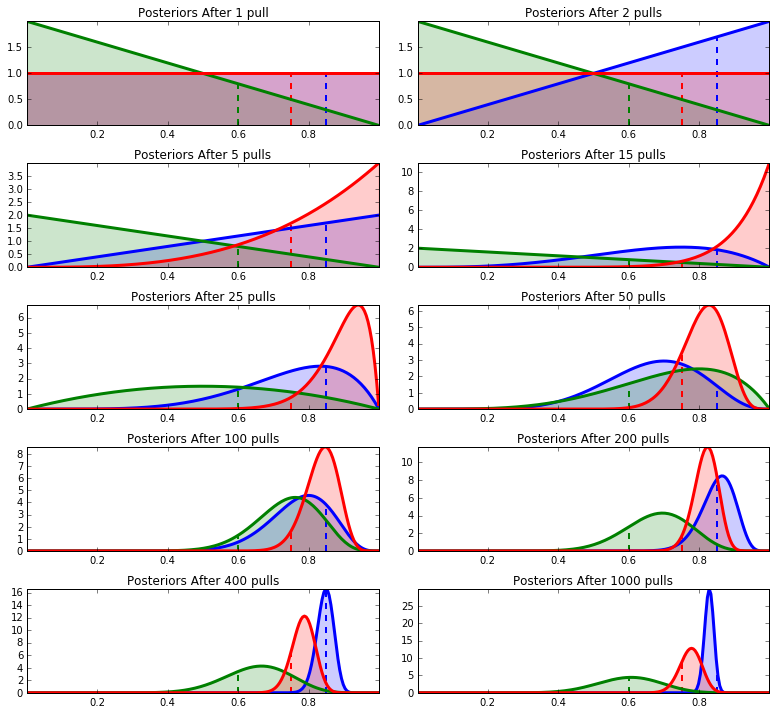

In [6]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

Note that we don't really care how accurate we become about the inference of the hidden probabilities &mdash; for this problem we are more interested in choosing the best bandit (or more accurately, becoming *more confident* in choosing the best bandit). For this reason, the distribution of the red bandit is very wide (representing ignorance about what that hidden probability might be) but we are reasonably confident that it is not the best, so the algorithm chooses to ignore it.

From the above, we can see that after 1000 pulls, the majority of the "blue" function leads the pack, hence we will almost always choose this arm. This is good, as this arm is indeed the best.

Deviations of the observed ratio from the highest probability is a measure of performance. For example,in the long run, optimally we can attain the reward/pull ratio of the maximum bandit probability. Long-term realized ratios less than the maximum represent inefficiencies. (Realized ratios larger than the maximum probability is due to randomness, and will eventually fall below). 

##### A Measure of *Good*

We need a metric to calculate how well we are doing. Recall the absolute *best* we can do is to always pick the bandit with the largest probability of winning. Denote this best bandit's probability by $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best bandit from the beginning. This motivates the *total regret* of a strategy, defined:

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}


where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice.  Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)


Below we plot the total regret of this simulation, including the scores of some other strategies:

1. Random: randomly choose a bandit to pull. If you can't beat this, just stop. 
2. Largest Bayesian credible bound: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. 
3. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior (see [4] )
3. Mean of posterior: choose the bandit with the largest posterior mean. This is what a human player (sans computer) would likely do. 
3. Largest proportion: pick the bandit with the current largest observed proportion of winning. 

The code for these are in the `other_strats.py`, where you can implement your own very easily.

In [8]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

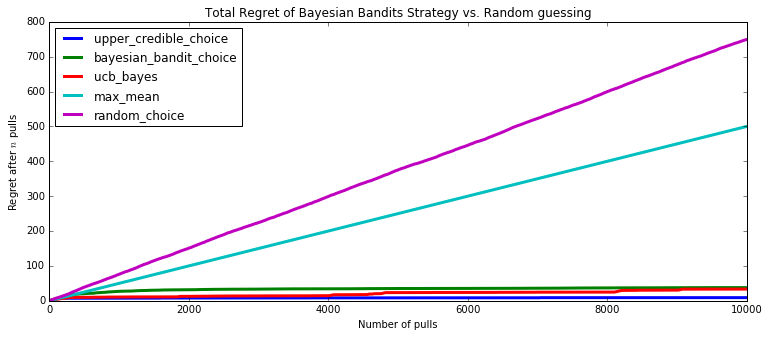

In [9]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

Like we wanted, Bayesian bandits and other strategies have decreasing rates of regret, representing we are achieving optimal choices. To be more scientific so as to remove any possible luck in the above simulation, we should instead look at the *expected total regret*:

$$\bar{R}_T = E[ R_T ] $$

It can be shown that any *sub-optimal* strategy's expected total regret is bounded below logarithmically. Formally,

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

Thus, any strategy that matches logarithmic-growing regret is said to "solve" the Multi-Armed Bandit problem [3].

Using the Law of Large Numbers, we can approximate Bayesian Bandit's expected total regret by performing the same experiment many times (500 times, to be fair):

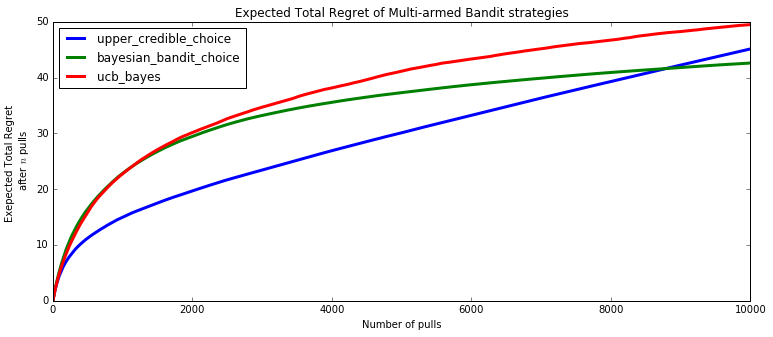

In [10]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

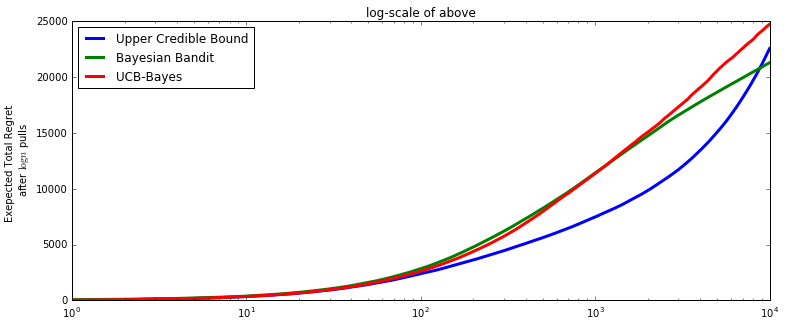

In [11]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

##### Extending the algorithm 


Because of the Bayesian Bandits algorithm's simplicity, it is easy to extend. Some possibilities:

- If interested in the *minimum* probability (eg: where prizes are a bad thing), simply choose $B = \text{argmin} \; X_b$ and proceed.

- Adding learning rates: Suppose the underlying environment may change over time. Technically the standard Bayesian Bandit algorithm would self-update itself (awesome) by noting that what it thought was the best is starting to fail more often. We can motivate the algorithm to learn changing environments quicker by simply adding a *rate* term upon updating:

        self.wins[choice] = rate*self.wins[choice] + result
        self.trials[choice] = rate*self.trials[choice] + 1

   If `rate < 1`, the algorithm will *forget* its previous wins quicker and there will be a downward  pressure towards ignorance. Conversely, setting `rate > 1` implies your algorithm will act more risky, and bet on earlier winners more often and be more resistant to changing environments. 

- Hierarchical algorithms: We can setup a Bayesian Bandit algorithm on top of smaller bandit algorithms. Suppose we have $N$ Bayesian Bandit models, each varying in some behavior (for example  different `rate` parameters, representing varying sensitivity to changing environments). On top of these $N$ models is another Bayesian Bandit learner that will select a sub-Bayesian Bandit. This chosen Bayesian Bandit will then make an internal choice as to which machine to pull. The super-Bayesian Bandit updates itself depending on whether the sub-Bayesian Bandit was correct or not. 

- Extending the rewards, denoted $y_a$ for bandit $a$, to random variables from a distribution $f_{y_a}(y)$ is straightforward. More generally, this problem can be rephrased as "Find the bandit with the largest expected value", as playing the bandit with the largest expected value is optimal. In the case above, $f_{y_a}$ was Bernoulli with probability $p_a$, hence the expected value for a bandit is equal to $p_a$, which is why it looks like we are aiming to maximize the probability of winning. If $f$ is not Bernoulli, and it is non-negative, which can be accomplished apriori by shifting the distribution (we assume we know $f$), then the algorithm behaves as before:

   For each round, 
    
   1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
   2. Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}\;\; X_b$.
   3. Observe the result,$R \sim f_{y_a}$, of pulling bandit $B$, and update your prior on bandit $B$.
   4. Return to 1

   The issue is in the sampling of $X_b$ drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior &mdash; this is easy to sample from. But now, with arbitrary distributions $f$, we have a non-trivial posterior. Sampling from these can be difficult.

- There has been some interest in extending the Bayesian Bandit algorithm to commenting systems. Recall in Chapter 4, we developed a ranking algorithm based on the Bayesian lower-bound of the proportion of upvotes to total votes. One problem with this approach is that it will bias the top rankings towards older comments, since older comments naturally have more votes (and hence the lower-bound is tighter to the true proportion). This creates a positive feedback cycle where older comments gain more votes, hence are displayed more often, hence gain more votes, etc. This pushes any new, potentially better comments, towards the bottom. J. Neufeld proposes a system to remedy this that uses a Bayesian Bandit solution.

His proposal is to consider each comment as a Bandit, with the number of pulls equal to the number of votes cast, and number of rewards as the number of upvotes, hence creating a $\text{Beta}(1+U,1+D)$ posterior. As visitors visit the page, samples are drawn from each bandit/comment, but instead of displaying the comment with the $\max$ sample, the comments are ranked according to the ranking of their respective samples. From J. Neufeld's blog [7]:

   > [The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments. 
   
Just for fun, though the colors explode, we watch the Bayesian Bandit algorithm learn 15 different options. 

[ 0.16258505  0.05910296  0.03821905  0.05130256  0.10824205  0.04921801
  0.11058887  0.11916844  0.10213984  0.06898978  0.10191715  0.06234474
  0.01322124  0.00628887  0.02035758  0.23042898  0.05479364  0.01623803
  0.0322196   0.04441325  0.23056911  0.07696711  0.50411325  0.1134037
  0.07263035  0.26393237  0.01529139  0.0012248   0.05292457  0.18248668
  0.0030078   0.17431957  0.05222666  0.04374928  0.03519215]


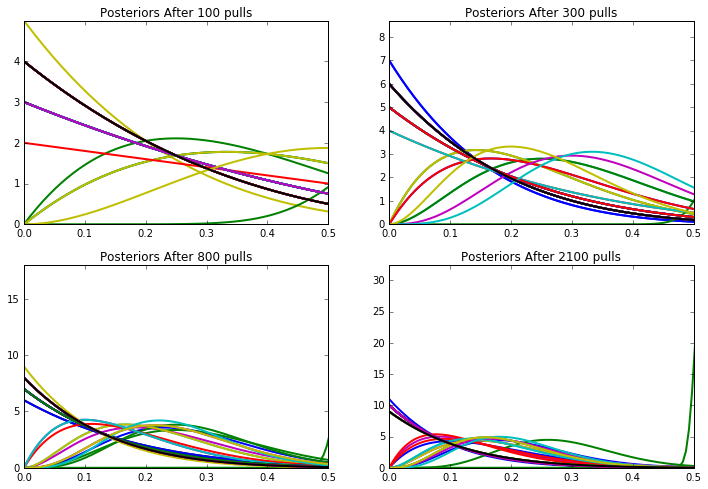

In [12]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)
